In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

CBcolors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

In [2]:
try: 
    if os.environ["GITHUB_WORKSPACE"] != None:
        root = os.environ["GITHUB_WORKSPACE"]
        inPath = os.path.join(root, "TestComponents", "TestSets", "WS1")
        outPath = os.path.join(root, "TestGraphs", "Outputs")  
except: 
    rootfrags = os.path.abspath('WS1.py').split("\\")
    root = ""
    for d in rootfrags:
        if d == "FieldNBalance":
            break
        else:
            root += d + "\\"
    inPath = os.path.join(root,"FieldNBalance","TestComponents", "TestSets", "WS1")
    outPath = os.path.join(root,"FieldNBalance","TestGraphs", "Outputs")   

In [3]:
Configs = pd.read_pickle(os.path.join(inPath, "FieldConfigs.pkl"))

In [4]:
observedCrop = pd.read_csv(os.path.join(inPath, "CropData.csv"), index_col=0)
observedCrop.sort_index(axis=0,inplace=True)
observedCrop['Date'] = pd.to_datetime(observedCrop['Date'])

In [5]:
observedSoil = pd.read_csv(os.path.join(inPath, "SoilData.csv"),index_col=0)
observedSoil.sort_index(axis=0,inplace=True)
observedSoil['Date'] = pd.to_datetime(observedSoil['Date'])
observedSoil['SoilMineralN'] = observedSoil.loc[:,['SoilN0_15', 'SoilN15_30']].sum(axis=1)

In [6]:
testFiles = []
tests = []
for file in os.listdir(os.path.join(inPath,"Outputs")):
    if file.endswith('.csv'):
        testFiles.append(file)
        tests.append(file.replace(".csv",""))

In [7]:
Alltests =[]
for t in testFiles[:]:  
    testframe = pd.read_csv(os.path.join(inPath, "Outputs", t),index_col=0,dayfirst=True,date_format='%d/%m/%Y %H:%M:%S %p')  
    Alltests.append(testframe)   

AllData = pd.concat(Alltests,axis=1,keys=tests)
AllData.sort_index(axis=0,inplace=True)
AllData.index = pd.to_datetime(AllData.index)

In [8]:
TestsFrame = pd.DataFrame(index = [tests],data=[x.split('_') for x in tests],columns = ['Site','N','Irr','Crop'])

In [9]:
ObsPredIndex = pd.MultiIndex.from_product([tests,AllData.index],names=['Treatment','Date'])
ObsPredCropN = pd.DataFrame(index = ObsPredIndex, columns = ['obs','pred'])
ObsPredCropN.loc[:,'Site'] =  [TestsFrame.loc[x,'Site'].values[0] for x in ObsPredCropN.index.get_level_values(0)]
ObsPredCropN.set_index('Site',append=True,inplace=True)
ObsPredCropN = ObsPredCropN.reorder_levels(['Site','Treatment','Date'],axis=0)
ObsPredCropN = ObsPredCropN.sort_index()

In [10]:
TestsFrame

,Site,N,Irr,Crop
HawkesBayRot3_N1_irr1_Onion,HawkesBayRot3,N1,irr1,Onion
HawkesBayRot3_N1_irr1_Ryegrass,HawkesBayRot3,N1,irr1,Ryegrass
HawkesBayRot3_N1_irr2_Onion,HawkesBayRot3,N1,irr2,Onion
HawkesBayRot3_N1_irr2_Ryegrass,HawkesBayRot3,N1,irr2,Ryegrass
HawkesBayRot3_N2_irr1_Onion,HawkesBayRot3,N2,irr1,Onion
...,...,...,...,...
LincolnRot2_N4_Irr1_RyeGrass,LincolnRot2,N4,Irr1,RyeGrass
LincolnRot2_N4_Irr2_Oat,LincolnRot2,N4,Irr2,Oat
LincolnRot2_N4_Irr2_PakChoi,LincolnRot2,N4,Irr2,PakChoi
LincolnRot2_N4_Irr2_Potato,LincolnRot2,N4,Irr2,Potato


In [11]:
ObsCropN = observedCrop.loc[:,['Date','CropN']]
ObsCropN.loc[:,'Date'] = [(ObsCropN.iloc[x,0] + dt.timedelta(hours=12)) for x in range(ObsCropN.index.size)]
ObsCropN.set_index('Date',append=True,inplace=True)
ObsCropN.columns = ['obs']
ObsCropN = ObsCropN.groupby(['Site','Date']).mean()
for t in tests:
    s = TestsFrame.loc[t,'Site'].values[0]
    obst = TestsFrame.loc[t,'Site'].values[0]+"_"+TestsFrame.loc[t,'N'].values[0]+"_"+TestsFrame.loc[t,'Irr'].values[0]
    obs = ObsCropN.loc[obst,:]
    obs.sort_index(inplace=True)
    dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'CropN')].index
    Pred = AllData.loc[dates,(t,'CropN')]
    pred = Pred.reindex(obs.index.values)
    pred.sort_index(axis=0, inplace=True)
    for d in obs.index.values:
        ObsPredCropN.loc[(s,t,d),'pred'] = pred[d]
        ObsPredCropN.loc[(s,t,d), 'obs'] = obs.loc[d,'obs']

In [12]:
sites = list(ObsPredCropN.index.get_level_values(0).drop_duplicates())

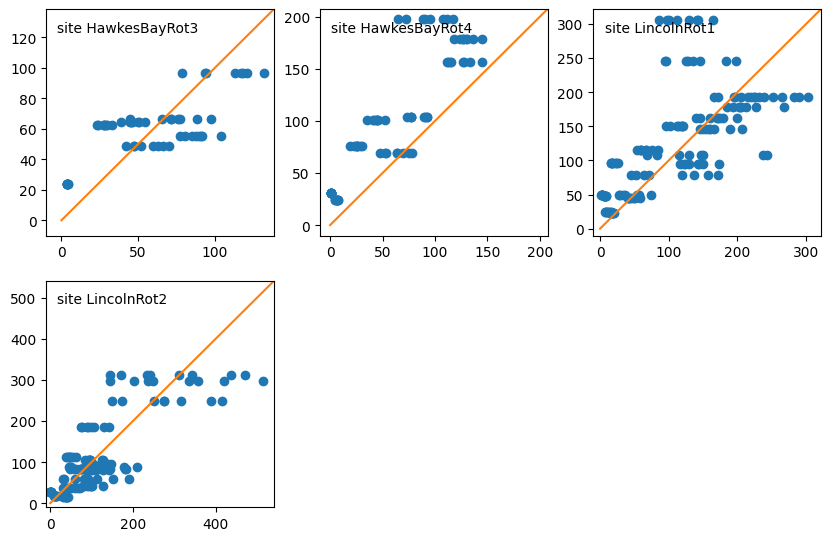

In [13]:
graph = plt.figure(figsize=(10,10))
pos = 1
for s in sites:
    Obs = ObsPredCropN.loc[s,'obs']
    Pred = ObsPredCropN.loc[s,'pred']
    #RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
    ax = graph.add_subplot(3,3,pos)
    plt.plot(Obs,Pred,'o')
    maxval = max(ObsPredCropN.loc[s,'obs'].max(),ObsPredCropN.loc[s,'pred'].max()) * 1.05
    plt.ylim(-10,maxval)
    plt.xlim(-10,maxval)
    plt.plot([0,maxval],[0,maxval],'-')
    plt.text(0.05,0.9,'site '+str(s),transform = ax.transAxes)
    #plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
    pos +=1

Text(0.5, 0, 'Observed')

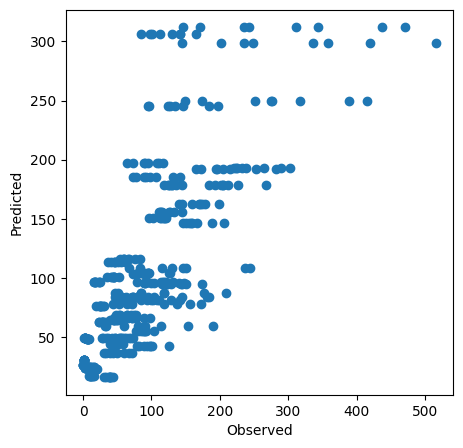

In [14]:
Obs = ObsPredCropN.obs.values
Pred = ObsPredCropN.pred.values
graph = plt.figure(figsize = (5,5))
ax = graph.add_subplot(1,1,1)
plt.plot(Obs,Pred,'o')
#RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
#plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
plt.ylabel('Predicted')
plt.xlabel('Observed')

In [15]:
ObsSoilN = observedSoil.loc[:,['Date','SoilMineralN']]
ObsSoilN.loc[:,'Date'] = [(ObsSoilN.iloc[x,0] + dt.timedelta(hours=12)) for x in range(ObsSoilN.index.size)]
ObsSoilN.set_index('Date',append=True,inplace=True)
ObsSoilN.columns = ['obs']
ObsSoilN = ObsSoilN.groupby(['Site','Date']).mean()
blankIndex = pd.MultiIndex.from_product([[],[],[]], names = ['site','test','date'])
ObsPredSoilN = pd.DataFrame(index = blankIndex, columns = ['obs','pred'])
for t in tests:
    s = TestsFrame.loc[t,'Site'].values[0]
    obst = TestsFrame.loc[t,'Site'].values[0]+"_"+TestsFrame.loc[t,'N'].values[0]+"_"+TestsFrame.loc[t,'Irr'].values[0]
    obs = ObsSoilN.loc[obst,:]
    dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'SoilMineralN')].index
    Pred = AllData.loc[dates,(t,'SoilMineralN')]
    pred = Pred.reindex(obs.index.values)
    for d in obs.index.values:
        ObsPredSoilN.loc[(s,t,d),'pred'] = pred[d]
        ObsPredSoilN.loc[(s,t,d), 'obs'] = obs.loc[d,'obs']

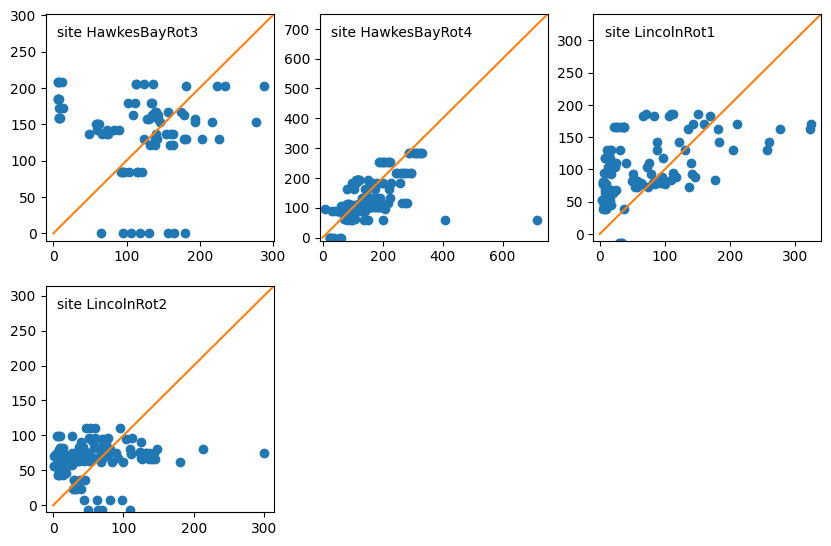

In [16]:
graph = plt.figure(figsize=(10,10))
pos = 1
for s in sites:
    Obs = ObsPredSoilN.loc[s,'obs']
    Pred = ObsPredSoilN.loc[s,'pred']
    #RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
    ax = graph.add_subplot(3,3,pos)
    plt.plot(Obs,Pred,'o')
    maxval = max(ObsPredSoilN.loc[s,'obs'].max(),ObsPredSoilN.loc[s,'pred'].max()) * 1.05
    plt.ylim(-10,maxval)
    plt.xlim(-10,maxval)
    plt.plot([0,maxval],[0,maxval],'-')
    plt.text(0.05,0.9,'site '+str(s),transform = ax.transAxes)
    #plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
    pos +=1

Text(0.5, 0, 'Observed')

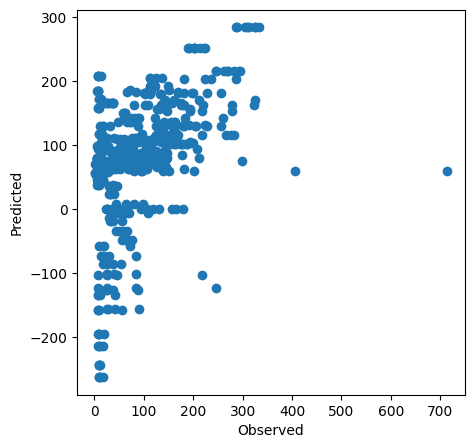

In [17]:
Obs = ObsPredSoilN.obs.values
Pred = ObsPredSoilN.pred.values
graph = plt.figure(figsize = (5,5))
ax = graph.add_subplot(1,1,1)
plt.plot(Obs,Pred,'o')
#RegStats = MUte.MathUtilities.CalcRegressionStats('LN',Pred,Obs)
#plt.text(0.05,0.8,'NSE = ' +str(RegStats.NSE),transform = ax.transAxes)
plt.ylabel('Predicted')
plt.xlabel('Observed')

In [22]:
sites

['HawkesBayRot3', 'HawkesBayRot4', 'LincolnRot1', 'LincolnRot2']

In [24]:
TestsFrame.loc[TestsFrame.Site==s,:].index.values

array([('LincolnRot2_N1_Irr1_Oat',), ('LincolnRot2_N1_Irr1_PakChoi',),
       ('LincolnRot2_N1_Irr1_Potato',), ('LincolnRot2_N1_Irr1_RyeGrass',),
       ('LincolnRot2_N1_Irr2_Oat',), ('LincolnRot2_N1_Irr2_PakChoi',),
       ('LincolnRot2_N1_Irr2_Potato',), ('LincolnRot2_N1_Irr2_RyeGrass',),
       ('LincolnRot2_N2_Irr1_Oat',), ('LincolnRot2_N2_Irr1_PakChoi',),
       ('LincolnRot2_N2_Irr1_Potato',), ('LincolnRot2_N2_Irr1_RyeGrass',),
       ('LincolnRot2_N2_Irr2_Oat',), ('LincolnRot2_N2_Irr2_PakChoi',),
       ('LincolnRot2_N2_Irr2_Potato',), ('LincolnRot2_N2_Irr2_RyeGrass',),
       ('LincolnRot2_N3_Irr1_Oat',), ('LincolnRot2_N3_Irr1_PakChoi',),
       ('LincolnRot2_N3_Irr1_Potato',), ('LincolnRot2_N3_Irr1_RyeGrass',),
       ('LincolnRot2_N3_Irr2_Oat',), ('LincolnRot2_N3_Irr2_PakChoi',),
       ('LincolnRot2_N3_Irr2_Potato',), ('LincolnRot2_N3_Irr2_RyeGrass',),
       ('LincolnRot2_N4_Irr1_Oat',), ('LincolnRot2_N4_Irr1_PakChoi',),
       ('LincolnRot2_N4_Irr1_Potato',), ('LincolnRot2

In [25]:
def setColor(treat):
    if "_N1_" in treat:
        return CBcolors['red']
    if "_N2_" in treat:
        return CBcolors['orange']
    if "_N3_" in treat:
        return CBcolors['green']
    else:
        return CBcolors['blue']

In [38]:
testsAtSite

array([('LincolnRot1_N1_Irr1_Broccoli',), ('LincolnRot1_N1_Irr1_Onion',),
       ('LincolnRot1_N1_Irr1_Ryegrass',), ('LincolnRot1_N1_Irr1_Wheat',),
       ('LincolnRot1_N1_Irr2_Broccoli',), ('LincolnRot1_N1_Irr2_Onion',),
       ('LincolnRot1_N1_Irr2_Ryegrass',), ('LincolnRot1_N1_Irr2_Wheat',),
       ('LincolnRot1_N2_Irr1_Broccoli',), ('LincolnRot1_N2_Irr1_Onion',),
       ('LincolnRot1_N2_Irr1_Ryegrass',), ('LincolnRot1_N2_Irr1_Wheat',),
       ('LincolnRot1_N2_Irr2_Broccoli',), ('LincolnRot1_N2_Irr2_Onion',),
       ('LincolnRot1_N2_Irr2_Ryegrass',), ('LincolnRot1_N2_Irr2_Wheat',),
       ('LincolnRot1_N3_Irr1_Broccoli',), ('LincolnRot1_N3_Irr1_Onion',),
       ('LincolnRot1_N3_Irr1_Ryegrass',), ('LincolnRot1_N3_Irr1_Wheat',),
       ('LincolnRot1_N3_Irr2_Broccoli',), ('LincolnRot1_N3_Irr2_Onion',),
       ('LincolnRot1_N3_Irr2_Ryegrass',), ('LincolnRot1_N3_Irr2_Wheat',),
       ('LincolnRot1_N4_Irr1_Broccoli',), ('LincolnRot1_N4_Irr1_Onion',),
       ('LincolnRot1_N4_Irr1_Ryegrass'

In [41]:
i1

('LincolnRot1_N1_Irr1_Broccoli',)

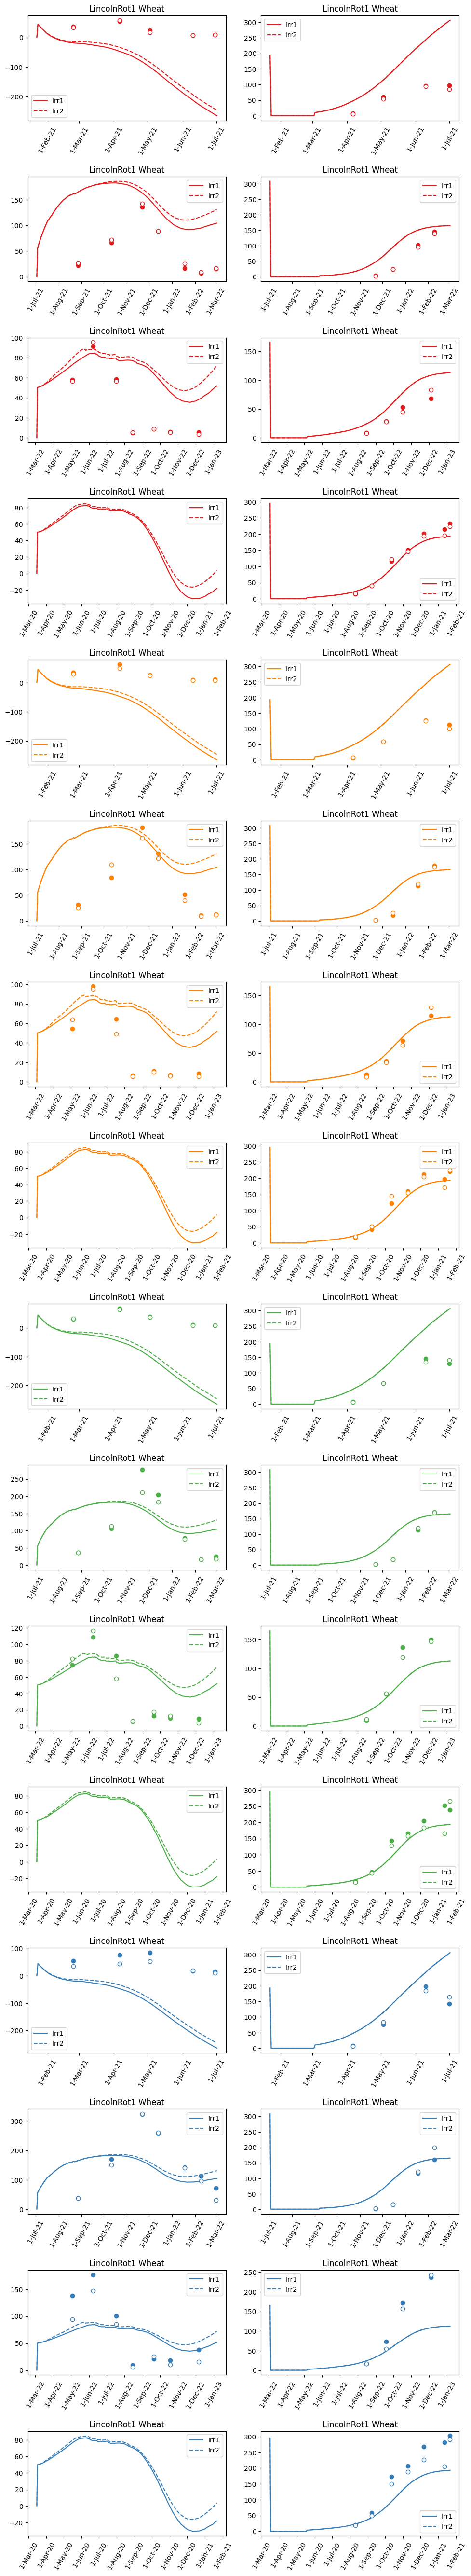

In [45]:
colors = ['orange','green']
Graph = plt.figure(figsize=(10,400))
pos = 1
row_num=len(tests)

for s in ['LincolnRot1']:#sites:
    testsAtSite = TestsFrame.loc[TestsFrame.Site==s,:].index.values
    cropsAtSite = []
    for t in testsAtSite:
        if 'Irr1' in t[0]:
            cropsAtSite.append(t[0])
    for i1 in cropsAtSite:
        dates = AllData.loc[Configs.loc["PriorHarvestDate",i1]:Configs.loc["CurrentHarvestDate",i1],(i1,'CropN')].index
        c = setColor(i1)  
        for v in ['SoilMineralN','CropN']:
            ax = Graph.add_subplot(row_num,2,pos)
            Data = AllData.loc[dates,(i1,v)]
            plt.plot(Data,"-",color=c,label='Irr1')
            i2 = i1.replace('Irr1','Irr2')
            Data = AllData.loc[dates,(i2,v)]
            plt.plot(Data,"--",color=c,label='Irr2')
            
            site = TestsFrame.loc[i1,'Site']+"_"+TestsFrame.loc[i1,'N']+"_Irr1"
            if v == 'CropN':
                sData = observedCrop.loc[site,:]
            if v == 'SoilMineralN':
                sData = observedSoil.loc[site,:]
            dFilter = [dates.min() <= sData['Date'].iloc[x] <= dates.max() for x in range(len(sData['Date']))]
            plt.plot(sData.loc[dFilter,'Date'],sData.loc[dFilter,v],'o',mec=c,mfc=c)

            site = TestsFrame.loc[i2,'Site']+"_"+TestsFrame.loc[i2,'N']+"_Irr2"
            if v == 'CropN':
                sData = observedCrop.loc[site,:]
            if v == 'SoilMineralN':
                sData = observedSoil.loc[site,:]
            dFilter = [dates.min() <= sData['Date'].iloc[x] <= dates.max() for x in range(len(sData['Date']))]
            plt.plot(sData.loc[dFilter,'Date'],sData.loc[dFilter,v],'o',mec=c,mfc='white')
            
            plt.title(t[0].split("_")[0]+" "+t[0].split("_")[3])
            plt.xticks(rotation=60)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%#d-%b-%y'))
            #plt.ylim(0,80for s in sites:0)
            plt.legend()
            pos+=1
Graph.tight_layout(pad=1.5)
plt.savefig(os.path.join(outPath, "WS1_TimeCourse.png"))

In [ ]:
# colors = ['orange','green']
# Graph = plt.figure(figsize=(10,10))
# pos = 1
# row_num=len(test_names)

# for t in test_names:
#     dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'CropN')].index
#     c = 0    
#     for v in ['ResidueN','SoilOMN']:
#         color = 'b'
#         ax = Graph.add_subplot(row_num,2,pos)
#         Data = AllData.loc[dates,(t,v)].cumsum()
#         plt.plot(Data,color=CBcolors[colors[c]],label=v)
#         plt.title(t)
#         plt.xticks(rotation=60)
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%#d-%b'))
#         plt.legend()
#         Graph.tight_layout(pad=1.5)
#         pos+=1
#         c+=1

In [ ]:
# colors = ['orange','green']
# Graph = plt.figure(figsize=(10,10))
# pos = 1
# row_num=len(test_names)

# for t in test_names:
#     dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'CropN')].index
#     c = 0    
#     for v in ['Drainage', 'Irrigation']:
#         color = 'b'
#         ax = Graph.add_subplot(row_num,2,pos)
#         Data = AllData.loc[dates,(t,v)].cumsum()
#         plt.plot(Data,color=CBcolors[colors[c]],label=v)
#         plt.title(t)
#         plt.xticks(rotation=60)
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%#d-%b'))
#         plt.legend()
#         Graph.tight_layout(pad=1.5)
#         pos+=1
#         c+=1

In [ ]:
# colors = ['orange','green']
# Graph = plt.figure(figsize=(10,10))
# pos = 1
# row_num=len(test_names)

# for t in test_names:
#     dates = AllData.loc[Configs.loc["PriorHarvestDate",t]:Configs.loc["CurrentHarvestDate",t],(t,'CropN')].index
#     c = 0    
#     for v in ['Green cover', 'RSWC']:
#         color = 'b'
#         ax = Graph.add_subplot(row_num,2,pos)
#         Data = AllData.loc[dates,(t,v)]
#         plt.plot(Data,color=CBcolors[colors[c]],label=v)
#         plt.title(t)
#         plt.xticks(rotation=60)
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%#d-%b'))
#         plt.legend()
#         Graph.tight_layout(pad=1.5)
#         pos+=1
#         c+=1